In [13]:
from scipy.io import arff
import pandas as pd

# Chargement dufichier ARFF
data = arff.loadarff('phpMawTba.arff')

# Conversion des données en DataFrame pandas
adult_census = pd.DataFrame(data[0])

# Affichage du DataFrame
print(adult_census.head())

    age     workclass    fnlwgt        education  education-num  \
0  25.0    b'Private'  226802.0          b'11th'            7.0   
1  38.0    b'Private'   89814.0       b'HS-grad'            9.0   
2  28.0  b'Local-gov'  336951.0    b'Assoc-acdm'           12.0   
3  44.0    b'Private'  160323.0  b'Some-college'           10.0   
4  18.0          b'?'  103497.0  b'Some-college'           10.0   

          marital-status            occupation  relationship      race  \
0       b'Never-married'  b'Machine-op-inspct'  b'Own-child'  b'Black'   
1  b'Married-civ-spouse'    b'Farming-fishing'    b'Husband'  b'White'   
2  b'Married-civ-spouse'    b'Protective-serv'    b'Husband'  b'White'   
3  b'Married-civ-spouse'  b'Machine-op-inspct'    b'Husband'  b'Black'   
4       b'Never-married'                  b'?'  b'Own-child'  b'White'   

         sex  capital-gain  capital-loss  hours-per-week    native-country  \
0    b'Male'           0.0           0.0            40.0  b'United-States'

In [14]:
target_name = "class"
numerical_columns = ["age", "capital-gain", "capital-loss", "hours-per-week"]

target = adult_census[target_name]
target.replace({b'<=50K': 0, b'>50K': 1}, inplace=True)
print(target.head())
data = adult_census[numerical_columns]

0    0
1    0
2    1
3    1
4    0
Name: class, dtype: int64


In [15]:
data.head(5)

,age,capital-gain,capital-loss,hours-per-week
0,25.0,0.0,0.0,40.0
1,38.0,0.0,0.0,50.0
2,28.0,0.0,0.0,40.0
3,44.0,7688.0,0.0,40.0
4,18.0,0.0,0.0,30.0


In [16]:
#Création d'un modèle prédictif simple composé d'un scaler suivi d'un classificateur de régression logistique:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

model = Pipeline(
    steps=[
        ("preprocessor", StandardScaler()),
        ("classifier", LogisticRegression()),
    ]
)

In [17]:
#Nous pouvons évaluer les performances de généralisation du modèle via une validation croisée
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target)
scores = cv_results["test_score"]
print(
    "Accuracy score via cross-validation:\n"
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

Accuracy score via cross-validation:
0.800 ± 0.003


In [18]:
model.set_params(classifier__C=1e-3)
cv_results = cross_validate(model, data, target)
scores = cv_results["test_score"]
print(
    "Accuracy score via cross-validation:\n"
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

Accuracy score via cross-validation:
0.787 ± 0.002


In [19]:
model.get_params()["classifier__C"]

0.001

In [20]:
for C in [1e-3, 1e-2, 1e-1, 1, 10]:
    model.set_params(classifier__C=C)
    cv_results = cross_validate(model, data, target)
    scores = cv_results["test_score"]
    print(
        f"Accuracy score via cross-validation with C={C}:\n"
        f"{scores.mean():.3f} ± {scores.std():.3f}"
    )
#Nous pouvons voir que tant que C est suffisamment élevé, le modèle semble bien fonctionner.

Accuracy score via cross-validation with C=0.001:
0.787 ± 0.002
Accuracy score via cross-validation with C=0.01:
0.799 ± 0.003
Accuracy score via cross-validation with C=0.1:
0.800 ± 0.003
Accuracy score via cross-validation with C=1:
0.800 ± 0.003
Accuracy score via cross-validation with C=10:
0.800 ± 0.003


**Optimiser les hyperparamètres à l'aide d'une approche de recherche par grille.**

In [21]:
#Rappel nous retirons la colonne "education-num" redondante.
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,b'Private',226802.0,b'11th',b'Never-married',b'Machine-op-inspct',b'Own-child',b'Black',b'Male',0.0,0.0,40.0,b'United-States'
1,38.0,b'Private',89814.0,b'HS-grad',b'Married-civ-spouse',b'Farming-fishing',b'Husband',b'White',b'Male',0.0,0.0,50.0,b'United-States'
2,28.0,b'Local-gov',336951.0,b'Assoc-acdm',b'Married-civ-spouse',b'Protective-serv',b'Husband',b'White',b'Male',0.0,0.0,40.0,b'United-States'
3,44.0,b'Private',160323.0,b'Some-college',b'Married-civ-spouse',b'Machine-op-inspct',b'Husband',b'Black',b'Male',7688.0,0.0,40.0,b'United-States'
4,18.0,b'?',103497.0,b'Some-college',b'Never-married',b'?',b'Own-child',b'White',b'Female',0.0,0.0,30.0,b'United-States'


In [22]:
#Séparation des données :
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)

In [23]:
#Sélection de toutes les colonnes catégorielles
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

In [24]:
#Encodage des données catégorielles avec Ordinal Encoder
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [("cat_preprocessor", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

In [25]:
#Nous utilisons un classificateur arborescent  pour prédire si une personne gagne ou non plus de 50 k$ par an.
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4),
        ),
    ]
)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

Réglage à l'aide d'une recherche par grille
Dans l'exercice précédent, nous avons utilisé une boucle for pour chaque hyperparamètre afin de trouver la meilleure combinaison sur une grille fixe de valeurs. GridSearchCV est une classe scikit-learn qui implémente une logique très similaire avec un code moins répétitif.

Voyons comment utiliser l'estimateur GridSearchCV pour effectuer une telle recherche. Étant donné que la recherche sur la grille est coûteuse, nous explorons uniquement la combinaison du taux d'apprentissage et du nombre maximum de nœuds.

In [26]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": (0.01, 0.1, 1, 10),
    "classifier__max_leaf_nodes": (3, 10, 30),
}
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=2)
model_grid_search.fit(data_train, target_train)

CPU times: user 5.99 s, sys: 531 ms, total: 6.52 s
Wall time: 16.9 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.01, 0.1, 1, 10),
                         'classifier__max_leaf_nodes': (3, 10, 30)})

In [27]:
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: {accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.88


L'estimateur GridSearchCV prend un paramètre param_grid qui définit tous les hyperparamètres et leurs valeurs associées. La grille de recherche se charge de créer toutes les combinaisons possibles et de les tester.

Le nombre de combinaisons est égal au produit du nombre de valeurs à explorer pour chaque paramètre (par exemple dans notre exemple 4 x 3 combinaisons). Ainsi, l’ajout de nouveaux paramètres à explorer avec leurs valeurs associées devient rapidement coûteux en termes de calcul.

Une fois la recherche par grille ajustée, elle peut être utilisée comme n'importe quel autre prédicteur en appelant prédire et prédire_proba. En interne, il utilise le modèle avec les meilleurs paramètres trouvés lors de l'ajustement.

Obtenez des prédictions pour les 5 premiers échantillons en utilisant l'estimateur avec les meilleurs paramètres.

In [28]:
model_grid_search.predict(data_test.iloc[0:5])
print(f"The best set of parameters is: {model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


In [29]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,1.869770,0.219538,0.642775,0.017384,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.867766,0.867649,0.867708,0.000058,1
4,1.486349,0.219633,0.563669,0.008250,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.866729,0.866557,0.866643,0.000086,2
7,0.352896,0.008536,0.138896,0.014507,1,10,"{'classifier__learning_rate': 1, 'classifier__...",0.856956,0.862244,0.859600,0.002644,3
6,0.639894,0.137223,0.208856,0.014791,1,3,"{'classifier__learning_rate': 1, 'classifier__...",0.858648,0.850560,0.854604,0.004044,4
3,0.626794,0.007972,0.246127,0.036290,0.1,3,"{'classifier__learning_rate': 0.1, 'classifier...",0.852752,0.854272,0.853512,0.000760,5


In [30]:
#Obtenir les noms des paramètres
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [31]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
5,0.1,30,0.867708,0.000058,1
4,0.1,10,0.866643,0.000086,2
7,1,10,0.859600,0.002644,3
6,1,3,0.854604,0.004044,4
3,0.1,3,0.853512,0.000760,5
8,1,30,0.852611,0.001006,6
2,0.01,30,0.845541,0.002289,7
1,0.01,10,0.817832,0.001124,8
0,0.01,3,0.797166,0.000715,9
11,10,30,0.351642,0.012903,10


In [32]:
#Heatmap
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["learning_rate"],
    columns=["max_leaf_nodes"],
)

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.797166,0.817832,0.845541
0.10,0.853512,0.866643,0.867708
1.00,0.854604,0.859600,0.852611
10.00,0.283476,0.262564,0.351642


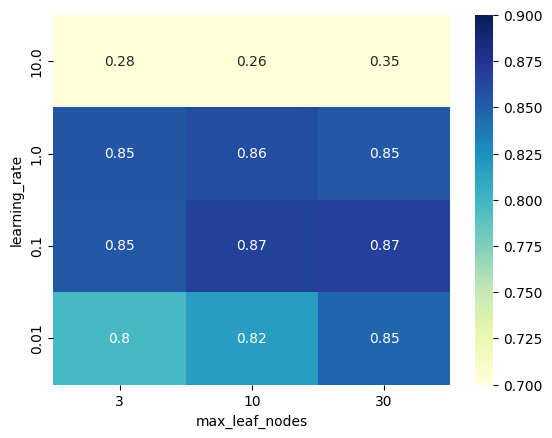

In [33]:
import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7, vmax=0.9
)
ax.invert_yaxis()

Les tableaux ci-dessus mettent en évidence les éléments suivants :

pour des valeurs trop élevées de learning_rate, les performances de généralisation du modèle sont dégradées et l'ajustement de la valeur de max_leaf_nodes ne peut pas résoudre ce problème ;
en dehors de cette région pathologique, on observe que le choix optimal de max_leaf_nodes dépend de la valeur de learning_rate ;
en particulier, on observe une « diagonale » de bons modèles avec une précision proche du maximum de 0,87 : lorsque la valeur de max_leaf_nodes est augmentée, il faut diminuer la valeur de learning_rate d'autant pour conserver une bonne précision.

Nous notons qu'en général, il n'existe pas de paramétrage optimal unique : 4 modèles sur les 12 configurations de paramètres atteignent la précision maximale (jusqu'aux petites fluctuations aléatoires provoquées par l'échantillonnage de l'ensemble d'apprentissage).

**Réglage des hyperparamètres par recherche aléatoire **


La classe RandomizedSearchCV permet une telle recherche stochastique(processus aléatoire) Il est utilisé de la même manière que GridSearchCV, mais les distributions d'échantillonnage doivent être spécifiées à la place des valeurs des paramètres. Par exemple, nous pouvons dessiner des candidats en utilisant une distribution log-uniforme car les paramètres qui nous intéressent prennent des valeurs positives avec une échelle logarithmique naturelle (0,1 est aussi proche de 1 que 10).
Nous optimisons maintenant 3 autres paramètres en plus de ceux que nous avons optimisés dans le notebook présentant le GridSearchCV :

l2_regularisation : elle correspond à la force de la régularisation ;
min_samples_leaf : il correspond au nombre minimum d'échantillons requis dans une feuille ;
max_bins : il correspond au nombre maximum de bins pour construire les histogrammes.
On rappelle la signification des 2 paramètres restants :

learning_rate : il correspond à la vitesse à laquelle le gradient-boosting corrige les résidus à chaque itération de boosting ;
max_leaf_nodes : il correspond au nombre maximum de feuilles pour chaque arbre de l'ensemble.

In [34]:
#Nous reprenons les précédentes étapes jusqu'à la pipeline
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

Maintenant, nous pouvons définir la recherche aléatoire en utilisant les différentes distributions. L'exécution de 10 itérations de validation croisée 5 fois pour les paramétrisations aléatoires de ce modèle sur cet ensemble de données peut prendre de 10 secondes à plusieurs minutes, en fonction de la vitesse de l'ordinateur hôte et du nombre de processeurs disponibles.

In [35]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "classifier__l2_regularization": loguniform(1e-6, 1e3),
    "classifier__learning_rate": loguniform(0.001, 10),
    "classifier__max_leaf_nodes": loguniform_int(2, 256),
    "classifier__min_samples_leaf": loguniform_int(1, 100),
    "classifier__max_bins": loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    verbose=1,
)
model_random_search.fit(data_train, target_train)
accuracy = model_random_search.score(data_test, target_test)

print(f"The test accuracy score of the best model is {accuracy:.2f}")

from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)
# get the parameter names
column_results = [f"param_{name}" for name in param_distributions.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False
)


def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The test accuracy score of the best model is 0.88
The best parameters are:
{'classifier__l2_regularization': 0.5254597214667629,
 'classifier__learning_rate': 0.07479138764334962,
 'classifier__max_bins': 162,
 'classifier__max_leaf_nodes': 127,
 'classifier__min_samples_leaf': 70}
CPU times: user 1min 58s, sys: 1.84 s, total: 2min
Wall time: 1min 15s


,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
5,0.52546,0.074791,127,70,162,0.866179,0.003059,1
2,0.0028,0.024994,115,26,144,0.865797,0.003102,2
9,0.080787,0.310284,111,41,106,0.859545,0.003133,3
8,272.796726,0.05627,28,11,94,0.858917,0.004042,4
1,0.022876,0.374456,16,21,32,0.854058,0.002858,5
6,649.438324,0.041975,136,27,103,0.852256,0.001328,6
0,0.000029,0.059202,172,16,18,0.851328,0.003093,7
7,0.001411,0.021252,15,23,18,0.848707,0.002706,8
3,0.008016,6.066277,5,51,12,0.390923,0.076213,9
4,0.011425,6.776633,35,30,74,0.270344,0.033141,10


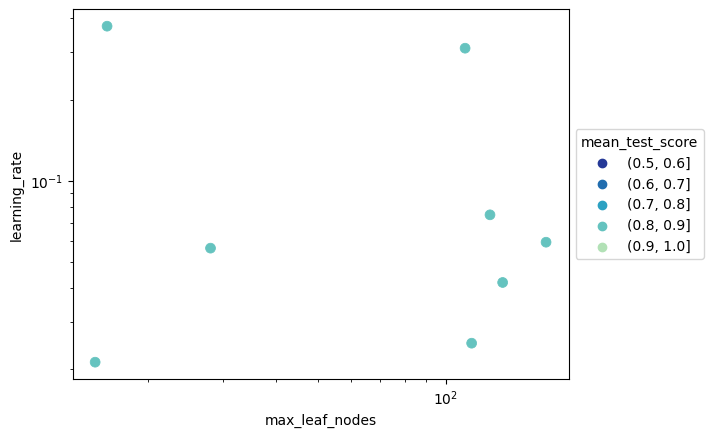

In [36]:
#Heatmap
import seaborn as sns
import numpy as np

df = pd.DataFrame(
    {
        "max_leaf_nodes": cv_results["max_leaf_nodes"],
        "learning_rate": cv_results["learning_rate"],
        "score_bin": pd.cut(
            cv_results["mean_test_score"], bins=np.linspace(0.5, 1.0, 6)
        ),
    }
)
sns.set_palette("YlGnBu_r")
ax = sns.scatterplot(
    data=df,
    x="max_leaf_nodes",
    y="learning_rate",
    hue="score_bin",
    s=50,
    color="k",
    edgecolor=None,
)
ax.set_xscale("log")
ax.set_yscale("log")

_ = ax.legend(
    title="mean_test_score", loc="center left", bbox_to_anchor=(1, 0.5)
)